In [12]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import copy
from sympy.solvers import solve
from sympy import Symbol
from sympy.functions import Abs

<h1 align="center"> Theoretical Bound on Agent Performance </h1>

### Agent Reward Function

When we talk about the agent's performance we are always interested in maximizing the agent driving utilities. For this study we don't worry about other (non-ego vehicle) performance. Agent Driving utility is to drive as fast possible (obviously less than or equal to max allowed) without colliding into other vehicle which lead to premature termination of the episode. This intent is supplied to agent via reward function defined below which encourages high speeds. 

$$ R_{t}(s_{t}, a_{t}) = \frac{v_{t+1}}{v_{max}} $$


### Understanding Behaviour of IDM vehicle (non- Ego Vehicles)

We used Intelligent driver model to model the human driven vehicles. Further, we realized that IDM doesn't really take into the account the range of perception available to the drivers to select its maneuver (acceleration). We made some changes to the model which emulates local view for Human Driven vehicles by placing a vehicle at the limit of local view if there is no vehicle within the range of perception.

Modified IDM model is given below.

### $$\dot{v_{\alpha}} = \begin{cases} a \bigg[ 1 - \big(\frac{v_{\alpha}}{v_{0}}\big)^{\delta} - \bigg( \frac{s^{*}(v_{\alpha},\Delta{V}_{\alpha})}{s_{\alpha}} \bigg)^{2} \bigg] & \text{ if } s_{\alpha} \lt s_{l} \\ a \bigg[ 1 - \big(\frac{v_{\alpha}}{v_{0}}\big)^{\delta} - \bigg( \frac{s^{*}_{lv}(v_{\alpha},\Delta{V}_{\alpha})}{s_{l}} \bigg)^{2} \bigg] & \text{ else } \end{cases} $$

where,

### $$ s^{*}_{lv}(v_{\alpha},\Delta{V}_{\alpha}) = s_{0} +  v_{\alpha}T + \frac{v_{\alpha} (v_{\alpha} - v_{0})}{2\sqrt{ab}}$$

In Ring Road with local view of 10 metres, if there is no vehicle within the local view of human driven vehicles (in front) the max speed at which vehicle can travel in steady state can be calculated using above equation.

$ s_{l} = 10.0$ m, $ a = 0.73 $m/s, $ s_{0} = 2$ m, $ v_{0} = 9$ m/s, $ T = 1.5 $s, $ \delta = 4 $, $ a = 0.73$ m/$s^{2}$, $ b = 1.67 $ m/$s^{2}$. Solve for $v_{\alpha}$ by equating $\dot{v_{\alpha}}$ to zero.

In [2]:
# v = valpha
sl = 10.0
a = 0.73
s0 = 2
v0 = 9
T = 1.5
delta = 4
a = 0.73
b = 1.67
abroot = np.sqrt(a * b)

In [14]:
v = Symbol('v')
res = solve(a*(1 - ((v/v0)**delta) - (((s0 + v*T + ((v*(v - v0))/(2 * abroot)))/sl)**2)), v)
print(res)

[-2.22688057155681, 7.33558668285629, 2.73977977809473 - 4.37819012311637*I, 2.73977977809473 + 4.37819012311637*I]


In [18]:
print("Possible Solutions are : ")
for i, sol in enumerate(res):
    print("Solution %d : "%(i+1), Abs(sol), " = ", Abs(sol) * 3.6, "km/hr ")

Possible Solutions are : 
Solution 1 :  2.22688057155681  =  8.01677005760453 km/hr 
Solution 2 :  7.33558668285629  =  26.4081120582827 km/hr 
Solution 3 :  5.16477898719883  =  18.5932043539158 km/hr 
Solution 4 :  5.16477898719883  =  18.5932043539158 km/hr 


Since, speed can't be negative we can rule out the possiblity of solution 1. Either solution 2, 3, or 4 can be our answer. Our simulations shows that at steady state vehicle settles at speed close to solution 3 and 4.

Simulation Steady state Speed = 5.43611

Analytical Steady state Speed = 5.16477

# Agent Behaviour when Pertutation is allowed

# All dataset  files location goes here

In [2]:
dataset_locs = {
    'only local view': "/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDM/OnlyLocalView//Results/dataset.pkl",
    "full access comm": "/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDM/CommFullAccess/Results/dataset.pkl",
    "restriced access comm": "/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDM/CommRestrictedAccess/Results/dataset.pkl",
    "full access comm with age": "/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDMAge/CommFullAccessAge/Results/dataset.pkl"
}

print(dataset_locs)

{'only local view': '/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDM/OnlyLocalView//Results/dataset.pkl', 'full access comm': '/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDM/CommFullAccess/Results/dataset.pkl', 'restriced access comm': '/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDM/CommRestrictedAccess/Results/dataset.pkl', 'full access comm with age': '/home/mayank/Videos/single-ring-road-with-light/SingleLaneIDMAge/CommFullAccessAge/Results/dataset.pkl'}


# Read all Dataset

In [3]:
def readPKL(fname):
    
    with open(fname, "rb") as handle:
        data_dict = pickle.load(handle)
    
    return copy.deepcopy(data_dict)

In [4]:
data_dict = {}
for case in dataset_locs.keys():
    data_dict[case] = readPKL(dataset_locs[case])


# Plot Agent Avg Speed

In [5]:
agent_vel = {}

for case in dataset_locs.keys():
    
    global_vel_data = {}
    
    for density in data_dict[case]["data"].keys():
        vel_data = []
        
        for episode_num in data_dict[case]["data"][density].keys():
            episode_data = []
            
            for step in range(0, len(data_dict[case]["data"][density][episode_num]["agent_vel"])):
                episode_data.append(data_dict[case]["data"][density][episode_num]["agent_vel"][step])
            
            vel_data.append(episode_data)
        
        global_vel_data[density] = copy.deepcopy(vel_data)
    
    agent_vel[case] = global_vel_data

In [6]:
# Length of episodes

In [7]:
avg_speeds_case = {}
density_dict = {}

for case in agent_vel.keys():
    
    avg_speeds = []
    densities = []
    
    for density in agent_vel[case].keys():
        densities.append(density)
        
        speed_sum = 0.0
        elements_count = 0
        for episode in agent_vel[case][density]:
            for vel in episode:
                speed_sum += vel
                elements_count += 1
        
        avg_speeds.append((speed_sum / elements_count) * 3.6)
    
    avg_speeds_case[case] = copy.deepcopy(avg_speeds)
    density_dict[case] = copy.deepcopy(densities)

In [8]:
avg_speeds_case

{'only local view': [12.446297008033763,
  11.417813125968555,
  9.498130960157729,
  8.112635317876025,
  6.424125692778512,
  4.9684768144419795],
 'full access comm': [13.946838496895143,
  12.359725615405655,
  10.231530030309015,
  7.964076996528209,
  6.464290830945328,
  4.817404410745194],
 'restriced access comm': [13.520460370907468,
  11.867128456137783,
  9.839106647129023,
  7.916081111331805,
  6.400338935518665,
  4.820495870956592],
 'full access comm with age': [13.319989050538299,
  11.677418401917327,
  9.829366032787341,
  7.698189519819775,
  5.912349189296889,
  4.875985835977721]}

only local view
0.2
full access comm
0.2
restriced access comm
0.2
full access comm with age
0.2


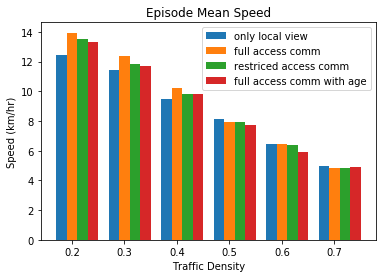

In [9]:
width = 0.2
start = -width

for case in avg_speeds_case.keys():
    print(case)
    plt.bar(np.arange(len(density_dict[case])) + start, avg_speeds_case[case], width=width, label=case)
    print(width)
    start += 0.2

plt.legend()
plt.xticks(ticks=np.arange(len(density_dict[case])), labels=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.xlabel("Traffic Density")
plt.ylabel("Speed (km/hr)")
plt.title("Episode Mean Speed")
plt.show()

In [10]:
avg_speeds_case

{'only local view': [12.446297008033763,
  11.417813125968555,
  9.498130960157729,
  8.112635317876025,
  6.424125692778512,
  4.9684768144419795],
 'full access comm': [13.946838496895143,
  12.359725615405655,
  10.231530030309015,
  7.964076996528209,
  6.464290830945328,
  4.817404410745194],
 'restriced access comm': [13.520460370907468,
  11.867128456137783,
  9.839106647129023,
  7.916081111331805,
  6.400338935518665,
  4.820495870956592],
 'full access comm with age': [13.319989050538299,
  11.677418401917327,
  9.829366032787341,
  7.698189519819775,
  5.912349189296889,
  4.875985835977721]}